## Cat and Dog image classification using Convolutional Neural Networks (CNNs)

### Getting the dataset from kaggle

In [1]:
# Importing kagglehub for accessing the kaggle dataset
!pip install kagglehub


[notice] A new release of pip is available: 24.1.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")

c:\Users\Nin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get the path to the downloladed dataset
path

'C:\\Users\\Nin\\.cache\\kagglehub\\datasets\\bhavikjikadara\\dog-and-cat-classification-dataset\\versions\\1'

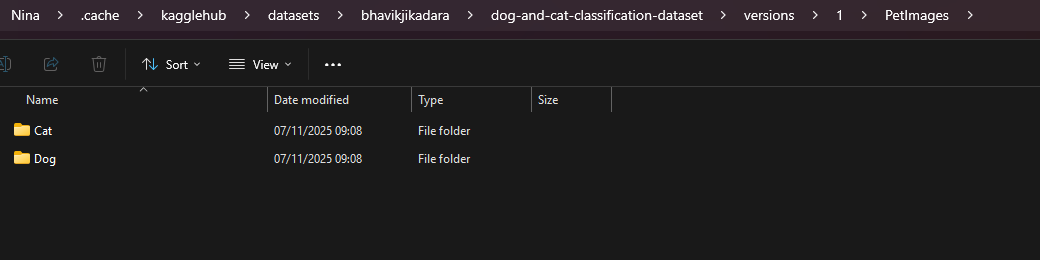

### Creating the train/validation/test(80%/10%/10%) folder structure

In [3]:
import os
import shutil

# Get the original folders
cat_dir = os.path.join(path, "PetImages/Cat")
dog_dir = os.path.join(path, "PetImages/Dog")

# New base dir for train/test split
base_dir = "PetData"
train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

for subset in [train_dir, validation_dir, test_dir]:
    for cls in ["cat", "dog"]:
        dir_path = os.path.join(subset, cls)
        if not os.path.exists(dir_path):
            os.makedirs(dir_path, exist_ok=True)

# Collect all image file names
cat_images = [f for f in os.listdir(cat_dir)]
dog_images = [f for f in os.listdir(dog_dir)]

# Split data - 80% for training, 10% for validation, 10% for testing
split_ratio_train = 0.8
split_ratio_val = 0.1  

# --- Cats ---
split_index_cat_train = int(len(cat_images) * split_ratio_train)
split_index_cat_val = split_index_cat_train + int(len(cat_images) * split_ratio_val)

train_cats = cat_images[:split_index_cat_train]
validation_cats = cat_images[split_index_cat_train:split_index_cat_val]
test_cats = cat_images[split_index_cat_val:]

# --- Dogs ---
split_index_dog_train = int(len(dog_images) * split_ratio_train)
split_index_dog_val = split_index_dog_train + int(len(dog_images) * split_ratio_val)

train_dogs = dog_images[:split_index_dog_train]
validation_dogs = dog_images[split_index_dog_train:split_index_dog_val]
test_dogs = dog_images[split_index_dog_val:]

def copy_images(file_list, src_dir, dst_dir):
    for fname in file_list:
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)
        if not os.path.exists(dst):
            try:
                shutil.copyfile(src, dst)
            except Exception as e:
                print(f"Skipped {fname}: {e}")

# Copy Cat images
copy_images(train_cats, cat_dir, os.path.join(train_dir, "cat"))
copy_images(validation_cats, cat_dir, os.path.join(validation_dir, "cat"))
copy_images(test_cats, cat_dir, os.path.join(test_dir, "cat"))

# Copy Dog images
copy_images(train_dogs, dog_dir, os.path.join(train_dir, "dog"))
copy_images(validation_dogs, dog_dir, os.path.join(validation_dir, "dog"))
copy_images(test_dogs, dog_dir, os.path.join(test_dir, "dog"))

In [4]:
print("Length of the original CAT directory (Amount of images): ", len(cat_images))
print("Length of the new CAT directory (Amount of images) - TRAIN, VALIDATION, TEST: ", len(train_cats), len(validation_cats), len(test_cats))

print("Length of the original DOG directory (Amount of images): ", len(dog_images))
print("Length of the new DOG directory (Amount of images) - TRAIN, VALIDATION, TEST: ", len(train_dogs), len(validation_cats), len(test_dogs))

Length of the original CAT directory (Amount of images):  12499
Length of the new CAT directory (Amount of images) - TRAIN, VALIDATION, TEST:  9999 1249 1251
Length of the original DOG directory (Amount of images):  12499
Length of the new DOG directory (Amount of images) - TRAIN, VALIDATION, TEST:  9999 1249 1251


In [97]:
class_names = ["cat", "dog"]
class_names

['cat', 'dog']

### Inspecting the data

In [5]:
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def view_random_image(target_dir, target_class):
    target_folder = target_dir + "/"  + target_class

    random_image = random.sample(os.listdir(target_folder), 1)
    
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")

    print(f"Image shape: {img.shape}")

    return img
    

Image shape: (353, 400, 3)
Image shape: (192, 288, 3)


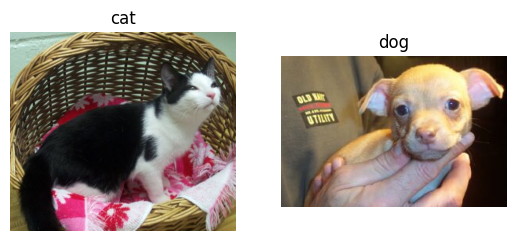

In [6]:
# View random image -> visualize the data
plt.figure()
plt.subplot(1, 2, 1)
cat_img = view_random_image(train_dir, "cat")
plt.subplot(1, 2, 2)
dog_img = view_random_image(train_dir, "dog")

### Preprocessing the images

In [8]:
import tensorflow as tf

tf.constant(cat_img)

<tf.Tensor: shape=(353, 400, 3), dtype=uint8, numpy=
array([[[175, 206, 191],
        [176, 207, 192],
        [176, 207, 192],
        ...,
        [130, 160, 136],
        [130, 160, 136],
        [130, 160, 136]],

       [[175, 206, 191],
        [176, 207, 192],
        [176, 207, 192],
        ...,
        [132, 162, 138],
        [131, 161, 137],
        [131, 161, 137]],

       [[175, 205, 193],
        [175, 205, 193],
        [176, 206, 194],
        ...,
        [133, 163, 139],
        [133, 163, 139],
        [133, 163, 139]],

       ...,

       [[120, 102,  52],
        [125, 107,  57],
        [128, 111,  59],
        ...,
        [159, 137,  62],
        [162, 140,  65],
        [163, 141,  66]],

       [[129, 113,  61],
        [136, 120,  68],
        [139, 124,  69],
        ...,
        [164, 142,  67],
        [166, 144,  69],
        [166, 147,  71]],

       [[135, 123,  63],
        [132, 120,  60],
        [129, 117,  59],
        ...,
        [167, 147,  7

In [117]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set random seed
tf.random.set_seed(42)

# Preprocess the images/Data augmentation (normalization, rotation, ...)
train_dataset_augmented = ImageDataGenerator(rescale=1/255.,
                                            brightness_range=(0.8, 1.2),
                                            rotation_range=30,
                                            shear_range=0.2,
                                            zoom_range=0.3,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            horizontal_flip=True)

In [127]:
# Create non-augmented and augmented data batches for visualization
train_batch_non_augmented = ImageDataGenerator(rescale=1/255.).flow_from_directory(train_dir,
                                                          target_size=(224,224),
                                                          batch_size=32,
                                                          class_mode='binary',
                                                          shuffle=False)

train_batch_augmented = train_dataset_augmented.flow_from_directory(train_dir,
                                                          target_size=(224,224),
                                                          batch_size=32,
                                                          class_mode='binary',
                                                          shuffle=False)

Found 19998 images belonging to 2 classes.
Found 19998 images belonging to 2 classes.


In [139]:
# Get data batch samples
images, labels = next(train_batch_non_augmented)
augmented_images, labels = next(train_batch_augmented)

print("Train batch images shape:", images.shape)
print("Train batch augumented images shape:", augmented_images.shape)

Train batch images shape: (32, 224, 224, 3)
Train batch augumented images shape: (32, 224, 224, 3)


Original image shape: (224, 224, 3)
Augmented image shape: (224, 224, 3)


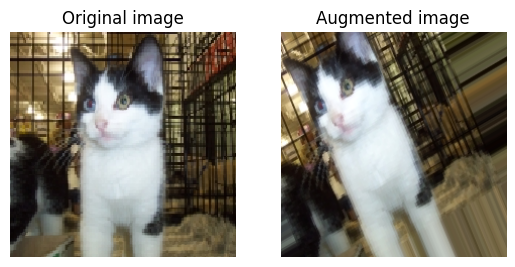

In [131]:
# Show original image and augmented image
random_number = random.randint(0, 31)
plt.figure()
plt.subplot(1, 2, 1)
plt.title(f"Original image")
plt.axis("off")
plt.imshow(images[random_number])
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")

print("Original image shape:", images[random_number].shape)
print("Augmented image shape:", augmented_images[random_number].shape)

In [13]:
# Shuiffling the data after visualization
train_batch_augmented = train_dataset_augmented.flow_from_directory(train_dir,
                                                          target_size=(224,224),
                                                          batch_size=32,
                                                          class_mode='binary',
                                                          shuffle=True)

validation_batch_non_augmented = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_dir,
                                                          target_size=(224,224),
                                                          batch_size=32,
                                                          class_mode='binary',
                                                          shuffle=False)

test_batch_non_augmented = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                          target_size=(224,224),
                                                          batch_size=32,
                                                          class_mode='binary',
                                                          shuffle=False)

Found 19998 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.
Found 2502 images belonging to 2 classes.


### Creating the baseline model (**model_1**)

In [111]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

model_1 = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

model_1.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)

history_1 = model_1.fit(train_batch_augmented, epochs=5, validation_data=validation_batch_non_augmented)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 215s 332ms/step - accuracy: 0.5545 - loss: 0.6762 - precision: 0.5462 - recall: 0.6466 - val_accuracy: 0.6769 - val_loss: 0.5851 - val_precision: 0.6545 - val_recall: 0.7494
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 311ms/step - accuracy: 0.6679 - loss: 0.6057 - precision: 0.6860 - recall: 0.6288 - val_accuracy: 0.7254 - val_loss: 0.5466 - val_precision: 0.6959 - val_recall: 0.8006
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 310ms/step - accuracy: 0.6816 - loss: 0.5926 - precision: 0.7028 - recall: 0.6351 - val_accuracy: 0.7394 - val_loss: 0.5278 - val_precision: 0.7056 - val_recall: 0.8215
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 321ms/step - accuracy: 0.7112 - loss: 0.5671 - precision: 0.7278 - recall: 0.6747 - val_accuracy: 0.7434 - val_loss: 0.5095 - val_precision: 0.7328 - val_recall: 0.7662
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 321ms/step - accuracy: 0.7100 - loss: 0.5592 - precision: 0.7266 - recall: 0.6658 - val_accuracy: 0.7526

### Evaluating the model

In [67]:
# Function for visualizing loss curves seperately for validation and training data
def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


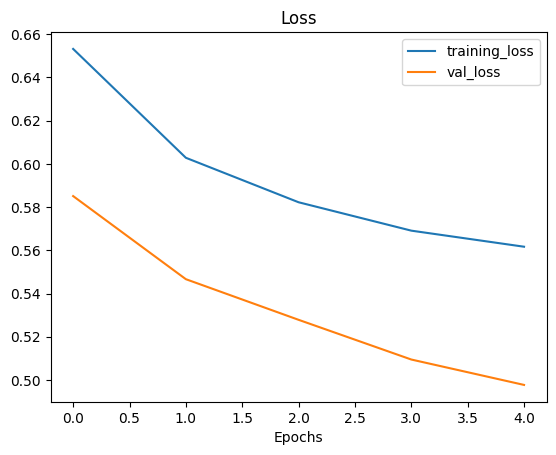

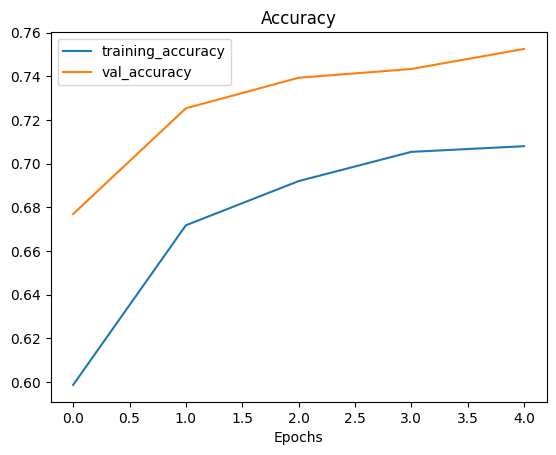

In [140]:
plot_loss_curves(history_1)

> Training loss and validation loss are very close in value and both are **decreasing** through epochs, loss: 0.5519 - val_loss: 0.5010.

Training accuracy and validation accuracy are also very close in value and both are **increasing** through epochs, accuracy: 0.7194 - val_accuracy: 0.7450.

The model is learning well...so let's try to improve it even more.

In [147]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def create_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    # fmt=.2f -> for normlized values
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=test_batch_non_augmented.class_indices.keys(),
                yticklabels=test_batch_non_augmented.class_indices.keys())
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


def calculate_f1_score(prec, rec, eps=1e-8):
    f1 = 2 * (prec * rec) / (prec + rec + eps)
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    return f1

c:\Users\Nin\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Precision: 0.7442
Recall:    0.7906
F1-score:  0.7667
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step


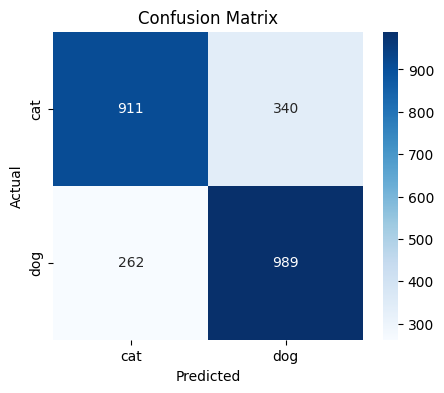

In [ ]:
loss, acc, prec, rec = model_1.evaluate(test_batch_non_augmented, verbose=0)
calculate_f1_score(prec, rec)

y_true = test_batch_non_augmented.classes  
y_pred_probs = model_1.predict(test_batch_non_augmented) 
y_pred = (y_pred_probs > 0.5).astype("int32")
create_confusion_matrix(y_true, y_pred)

The model prioritizes finding positives (good recall) over being careful about false alarms (precision).

In [33]:
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

### Improving the model (**model_2**)
To try to improve the model I added a **Dropout** layer, of 50%, before the last Dense layer.

In [35]:
from tensorflow.keras.layers import Dropout

# Added dropout
model_2 = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

model_2.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)

history_2 = model_2.fit(train_batch_augmented, epochs=5, validation_data=validation_batch_non_augmented)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 307ms/step - accuracy: 0.5606 - loss: 0.6660 - precision: 0.5661 - recall: 0.5954 - val_accuracy: 0.6577 - val_loss: 0.6090 - val_precision: 0.6315 - val_recall: 0.7574
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 189s 299ms/step - accuracy: 0.6447 - loss: 0.6171 - precision: 0.6765 - recall: 0.5406 - val_accuracy: 0.7030 - val_loss: 0.5683 - val_precision: 0.6896 - val_recall: 0.7382
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 296ms/step - accuracy: 0.6780 - loss: 0.5939 - precision: 0.7038 - recall: 0.6012 - val_accuracy: 0.6962 - val_loss: 0.5770 - val_precision: 0.6644 - val_recall: 0.7926
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 187s 297ms/step - accuracy: 0.6836 - loss: 0.5846 - precision: 0.7051 - recall: 0.6245 - val_accuracy: 0.7298 - val_loss: 0.5278 - val_precision: 0.7191 - val_recall: 0.7542
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 188s 298ms/step - accuracy: 0.6942 - loss: 0.5766 - precision: 0.7128 - recall: 0.6481 - val_accuracy: 0.7458

### Evaluating the model

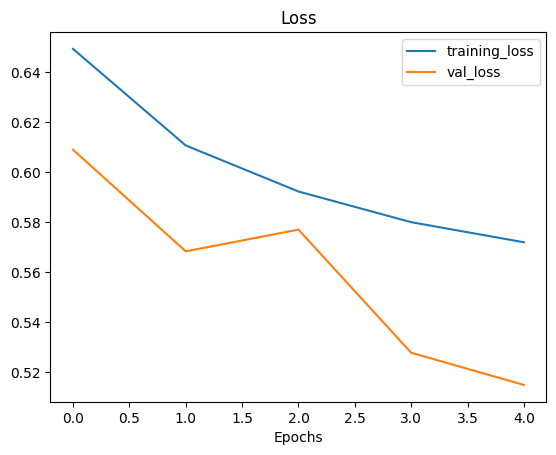

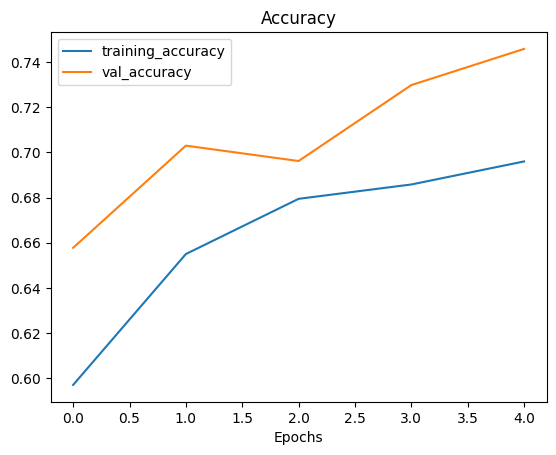

In [36]:
plot_loss_curves(history_2)

> This model performed slightly worse than model_1, with ending values of accuracy: 0.6942 - val_accuracy: 0.7458, and loss: 0.5766 - val_loss: 0.5149.

Both training loss and validation loss are decreasing overall, which is great — it suggests the model is learning. 

That small spike in validation loss (from epoch 1 to 2) might suggest **early signs of overfitting**, where the model was fitting the training data too well but not generalizing perfectly to unseen data.

Since validation loss continued decreasing again after epoch 2, we can say it corrected itself — meaning it's not strong overfitting, but likely just noise or small instability in that epoch.

c:\Users\Nin\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Precision: 0.7470
Recall:    0.7410
F1-score:  0.7440
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step


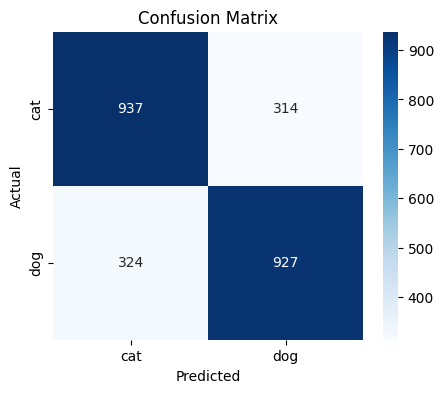

In [37]:
loss, acc, prec, rec = model_2.evaluate(test_batch_non_augmented, verbose=0)
calculate_f1_score(prec, rec)

y_true = test_batch_non_augmented.classes  
y_pred_probs = model_2.predict(test_batch_non_augmented) 
y_pred = (y_pred_probs > 0.5).astype("int32")
create_confusion_matrix(y_true, y_pred)

> Metrics

Precision ~0.747
~75% of predicted “dogs” were actually dogs. (So ~25% of “dog” predictions were false.)

Recall ~0.741
~74% of real dogs were correctly identified. (So ~26% of dogs were missed.)

F1 ~0.744
Balanced average between precision & recall.

>**Comparison to before Dropout**

Previously, I had something like:

Precision ≈ 0.73

Recall ≈ 0.84

F1 ≈ 0.78

Now (with Dropout):

Precision **↑** slightly (0.73 → 0.75)

Recall **↓** (0.84 → 0.74)

F1 **↓** slightly (0.78 → 0.74)



Dropout made the model a little more cautious:

* It reduced overfitting → fewer false positives (cats wrongly flagged as dogs decreased relatively).

* But it also made the model miss more actual dogs (recall dropped).

In short: Precision improved, Recall worsened.

In [38]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

### Improving the model (**model_3**)

This time I added another Conv2D layer before the MaxPooling layer, making the model more complex. And droppped the dropout percantage to 30%.

In [40]:
# Added more Convolutional layers
model_3 = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_3.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)

history_3 = model_3.fit(train_batch_augmented, epochs=5, validation_data=validation_batch_non_augmented)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 225s 355ms/step - accuracy: 0.5131 - loss: 0.6932 - precision: 0.5137 - recall: 0.4797 - val_accuracy: 0.5693 - val_loss: 0.6644 - val_precision: 0.5404 - val_recall: 0.9271
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 232s 369ms/step - accuracy: 0.6038 - loss: 0.6629 - precision: 0.6003 - recall: 0.6493 - val_accuracy: 0.6994 - val_loss: 0.6027 - val_precision: 0.6939 - val_recall: 0.7134
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 226s 359ms/step - accuracy: 0.6496 - loss: 0.6253 - precision: 0.6604 - recall: 0.6136 - val_accuracy: 0.7342 - val_loss: 0.5420 - val_precision: 0.7146 - val_recall: 0.7798
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 232s 367ms/step - accuracy: 0.6833 - loss: 0.5901 - precision: 0.6978 - recall: 0.6512 - val_accuracy: 0.7378 - val_loss: 0.5207 - val_precision: 0.7103 - val_recall: 0.8030
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 229s 363ms/step - accuracy: 0.6989 - loss: 0.5738 - precision: 0.7155 - recall: 0.6625 - val_accuracy: 0.7634

### Evaluating the model 

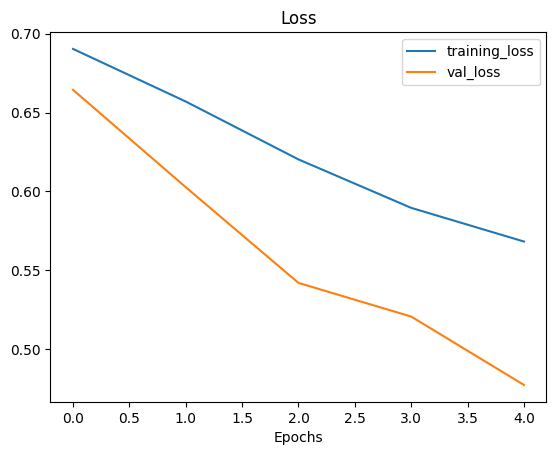

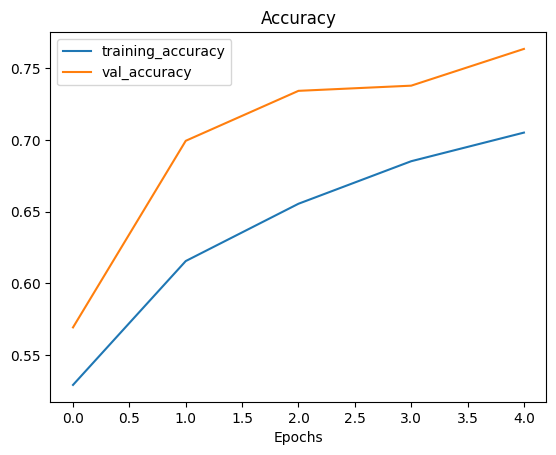

In [41]:
plot_loss_curves(history_3)

c:\Users\Nin\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Precision: 0.7727
Recall:    0.7882
F1-score:  0.7804
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step


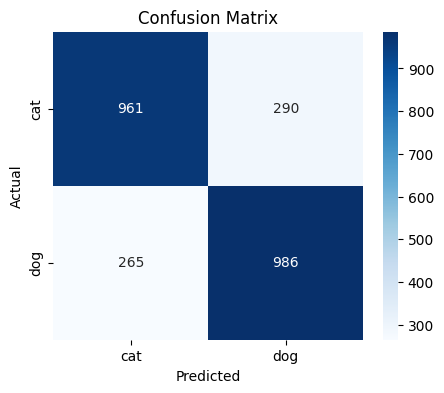

In [42]:
loss, acc, prec, rec = model_3.evaluate(test_batch_non_augmented, verbose=0)
calculate_f1_score(prec, rec)

y_true = test_batch_non_augmented.classes  
y_pred_probs = model_3.predict(test_batch_non_augmented) 
y_pred = (y_pred_probs > 0.5).astype("int32")
create_confusion_matrix(y_true, y_pred)

Best balance so far — precision ≈ recall ≈ accuracy. 


Precision and recall are very close (77–79%).

~290 cats got misclassified as dogs.

~265 dogs got misclassified as cats.

Misclassifications are relatively symmetric which means the model doesn’t strongly favor one class.

Improvement vs earlier runs

Compared to my first model (Precision ~0.73, Recall ~0.84), this one is more balanced: precision went up, recall dropped slightly, F1 stayed similar (~0.78).

Compared to the dropout-only run (~0.74 F1), this one is better overall.

> This model is most stable and balanced so far — precision and recall are nearly equal, F1 is strong (~0.78), and the confusion matrix shows no major class bias.

In [43]:
model_3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 51, 51, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 49, 49, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 24, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         5,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,775 (124.12 KB)

 Trainable params: 10,591 (41.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,184 (82.75 KB)

### Improving the model (**model_4**)

This time I will try to increase the learning rate of the Adam optimizer. Default value is 0.001 so I will set it to 0.01. 

In [148]:
model_4 = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_4.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.01),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)

history_4 = model_4.fit(train_batch_augmented, epochs=5, validation_data=validation_batch_non_augmented)

Epoch 1/5


c:\Users\Nin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 371ms/step - accuracy: 0.5114 - loss: 0.7162 - precision: 0.4395 - recall: 0.2156 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 225s 357ms/step - accuracy: 0.5419 - loss: 0.6927 - precision: 0.5419 - recall: 0.2670 - val_accuracy: 0.5000 - val_loss: 0.6935 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 230s 365ms/step - accuracy: 0.5374 - loss: 0.6923 - precision: 0.5372 - recall: 0.8709 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 231s 366ms/step - accuracy: 0.4840 - loss: 0.6944 - precision: 0.4134 - recall: 0.2893 - val_accuracy: 0.5000 - val_loss: 0.6932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 228s 362ms/step - accuracy: 0.4628 - loss: 0.6944 - precision: 0.4705 - recall: 0.6448 - val_accuracy: 

### Evaluating the model

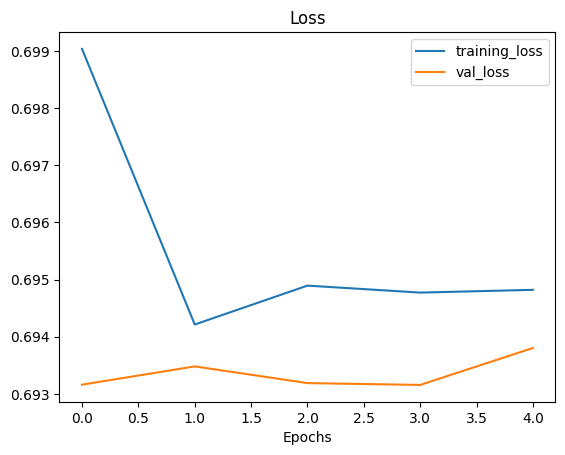

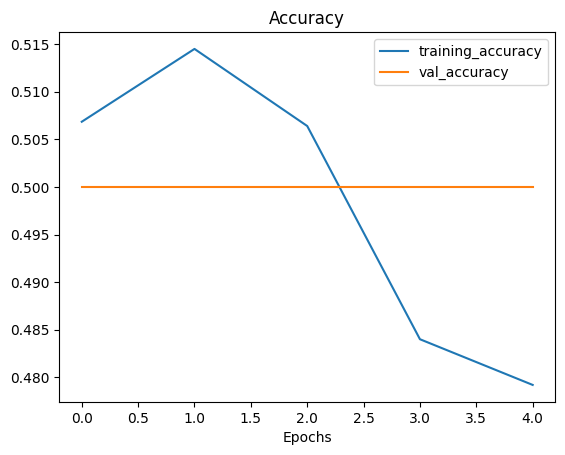

In [150]:
plot_loss_curves(history_4)

c:\Users\Nin\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step


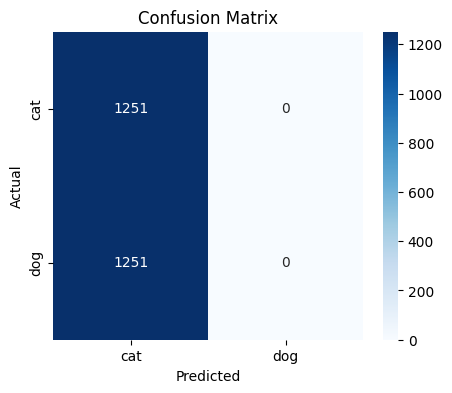

In [151]:
loss, acc, prec, rec = model_4.evaluate(test_batch_non_augmented, verbose=0)
calculate_f1_score(prec, rec)

y_true = test_batch_non_augmented.classes  
y_pred_probs = model_4.predict(test_batch_non_augmented) 
y_pred = (y_pred_probs > 0.5).astype("int32")
create_confusion_matrix(y_true, y_pred)

> This model is the worst one so far, with loss and accuracy around ~50% the model is basically guessing randomly. This is because the model is not learning anything from the data. **too few epochs + too high learning rate**

In [47]:
model_4.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 51, 51, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 49, 49, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │         5,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,775 (124.12 KB)

 Trainable params: 10,591 (41.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,184 (82.75 KB)

### Improving the model (model_5)

This time I will try the default learning rate and increse the number of epoch to 20.

In [76]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

model_5 = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(filters=10,
           kernel_size=3,
           strides=1,
           padding="valid",
           activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model_5.compile(
    loss="binary_crossentropy",
    optimizer=Adam(),
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)

history_5 = model_5.fit(train_batch_augmented, epochs=20, validation_data=validation_batch_non_augmented)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 239s 376ms/step - accuracy: 0.5312 - loss: 0.6903 - precision: 0.5266 - recall: 0.5208 - val_accuracy: 0.6305 - val_loss: 0.6620 - val_precision: 0.6712 - val_recall: 0.5116
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 234s 370ms/step - accuracy: 0.5948 - loss: 0.6699 - precision: 0.5911 - recall: 0.6393 - val_accuracy: 0.6597 - val_loss: 0.6097 - val_precision: 0.6283 - val_recall: 0.7822
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 229s 364ms/step - accuracy: 0.6393 - loss: 0.6373 - precision: 0.6424 - recall: 0.6074 - val_accuracy: 0.6918 - val_loss: 0.5848 - val_precision: 0.6550 - val_recall: 0.8102
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 233s 369ms/step - accuracy: 0.6619 - loss: 0.6181 - precision: 0.6716 - recall: 0.6226 - val_accuracy: 0.7242 - val_loss: 0.5389 - val_precision: 0.7361 - val_recall: 0.6990
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 237s 375ms/step - accuracy: 0.6739 - loss: 0.6037 - precision: 0.6881 - recall: 0.6484 - val_accuracy: 0

### Evaluating the model

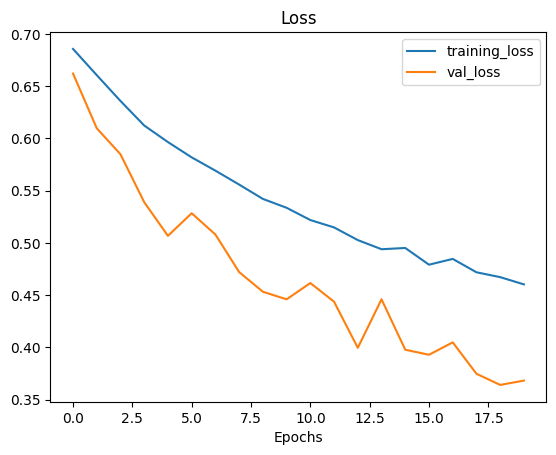

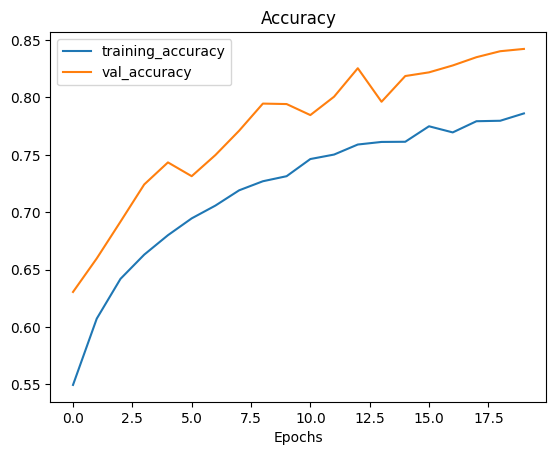

In [77]:
plot_loss_curves(history_5)

Training loss decreases steadily, meaning the model is learning.

Validation loss also decreases and even dips below the training loss.
This suggests the model generalizes well and benefits from regularization.


Training accuracy improves steadily.
Validation accuracy improves faster and stays consistently higher than training accuracy. 

Validation accuracy > training accuracy – Likely due to augmentation, dropout, or dataset differences.

> Best so far – Compared to previous models (where val_acc was ~0.74–0.82), this one reaches ~0.84, which is stronger.

Precision: 0.8216
Recall:    0.8689
F1-score:  0.8446
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step


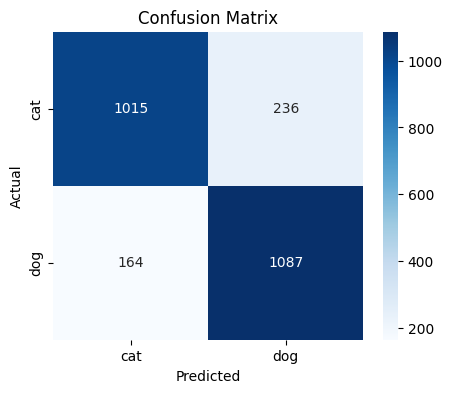

In [87]:
loss, acc, prec, rec = model_5.evaluate(test_batch_non_augmented, verbose=0)
calculate_f1_score(prec, rec)

y_true = test_batch_non_augmented.classes  
y_pred_probs = model_5.predict(test_batch_non_augmented) 
y_pred = (y_pred_probs > 0.5).astype("int32")
create_confusion_matrix(y_true, y_pred)

* Precision = 0.82 → When the model predicts "dog", it’s correct ~82% of the time.

* Recall = 0.87 → Out of all actual dogs, it correctly finds ~87%.

* F1 = 0.84 → Balanced performance (not biased toward precision or recall).


Dogs are classified slightly better than cats (lower error rate: 164 vs 236 mistakes).

In [84]:
model_5.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 220, 220, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 108, 108, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 106, 106, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 51, 51, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 49, 49, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         5,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,775 (124.12 KB)

 Trainable params: 10,591 (41.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 21,184 (82.75 KB)

### Saving the best model so far...

In [81]:
model_5.save("custom_cnn_model_5.keras")

## Transfer learning

In [14]:
RESNET_URL = "https://www.kaggle.com/models/tensorflow/resnet-50/TensorFlow2/feature-vector/1"
EFFICIENTNET_URL = "https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2"

In [15]:
print(train_batch_augmented.class_indices)

{'cat': 0, 'dog': 1}


For the SOTA models I had to install tf_keras otherwise an error pops up: `Only instances of keras.Layer can be added to a Sequential model.` The reason behind the error is caused somewhere within new tensorflow verions. For my code to work I would have to either uninstall my current version(2.17) and install an older version of tensorflow(2.15) which would mean running each cell again or just installing the tf_keras. Which is why i decided to go with this approach.

In [61]:
pip install tf_keras

Note: you may need to restart the kernel to use updated packages.


In [62]:
import tf_keras
import tensorflow_hub as hub

def create_model(model_url, num_classes = 1):
    """
    Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
    """
    feature_extractor_layer = hub.KerasLayer(model_url, 
                                            trainable=False,
                                            name="feature_extraction_layer",
                                            input_shape=(224, 224, 3))
    
    model = tf_keras.Sequential([
        feature_extractor_layer,
        tf_keras.layers.Dense(num_classes, activation="sigmoid", name="output_layer")
    ])

    return model

### Resnet50

In [63]:
resnet_model = create_model(RESNET_URL)

In [169]:
resnet_model.compile(loss="binary_crossentropy",
                     optimizer= tf_keras.optimizers.Adam(),
                     metrics=["accuracy", tf_keras.metrics.Precision(name="precision"), tf_keras.metrics.Recall(name="recall")])

resnet_history = resnet_model.fit(train_batch_augmented,
                                  epochs=5, 
                                  steps_per_epoch=len(train_batch_augmented),
                                  validation_data=validation_batch_non_augmented,
                                  validation_steps=len(validation_batch_non_augmented))

Epoch 1/5
625/625 [==============================] - 777s 1s/step - loss: 0.0783 - accuracy: 0.9865 - precision: 0.9841 - recall: 0.9890 - val_loss: 1.6923 - val_accuracy: 0.7270 - val_precision: 0.6468 - val_recall: 1.0000
Epoch 2/5
625/625 [==============================] - 848s 1s/step - loss: 0.0678 - accuracy: 0.9893 - precision: 0.9891 - recall: 0.9896 - val_loss: 1.1290 - val_accuracy: 0.8415 - val_precision: 0.7593 - val_recall: 1.0000
Epoch 3/5
625/625 [==============================] - 837s 1s/step - loss: 0.0384 - accuracy: 0.9935 - precision: 0.9923 - recall: 0.9947 - val_loss: 0.4116 - val_accuracy: 0.9440 - val_precision: 0.8992 - val_recall: 1.0000
Epoch 4/5
625/625 [==============================] - 840s 1s/step - loss: 0.0224 - accuracy: 0.9957 - precision: 0.9954 - recall: 0.9960 - val_loss: 0.3360 - val_accuracy: 0.9524 - val_precision: 0.9130 - val_recall: 1.0000
Epoch 5/5
625/625 [==============================] - 836s 1s/step - loss: 0.0218 - accuracy: 0.9955 - pr

### Evaluate resnet model

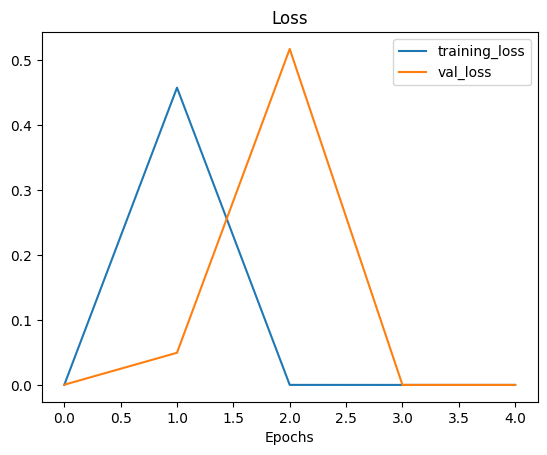

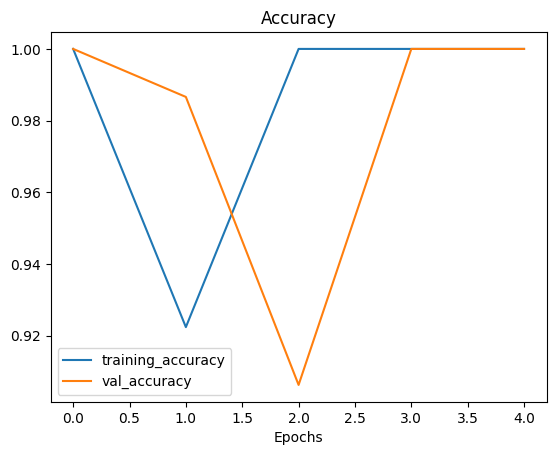

In [165]:
plot_loss_curves(resnet_history)


>Loss

Training loss steadily decreases.
Validation loss is much lower than training loss, and it stays very low.

This usually means the model generalizes very well. Although this might also be because strong data augmentation is applied to training data, making training harder than validation.

>Accuracy

Training accuracy increases to ~98.5%.
Validation accuracy is even higher (~99.2%+).

Model is well-regularized (dropout, BN, etc.).

Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
7/7 [==============================] - 8s 1s/step


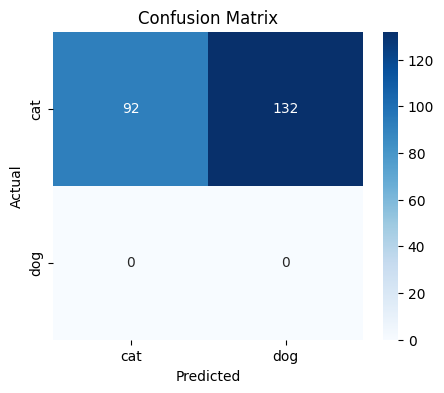

In [168]:
steps = int(0.1 * len(test_batch_non_augmented))

loss, acc, pred, rec = resnet_model.evaluate(test_batch_non_augmented, verbose=0, steps=steps)

calculate_f1_score(pred, rec)

y_true = test_batch_non_augmented.classes[:steps * test_batch_non_augmented.batch_size]  
y_pred_probs = resnet_model.predict(test_batch_non_augmented, steps=steps) 
y_pred = (y_pred_probs > 0.5).astype("int32")
create_confusion_matrix(y_true, y_pred)

### Effiecientnet

In [70]:
efficientnet_model = create_model(EFFICIENTNET_URL)

In [71]:
efficientnet_model.compile(loss="binary_crossentropy",
                     optimizer= tf_keras.optimizers.Adam(),
                     metrics=["accuracy"])

efficientnet_history = efficientnet_model.fit(train_batch_augmented,
                                  epochs=5, 
                                  steps_per_epoch=len(train_batch_augmented),
                                  validation_data=validation_batch_non_augmented,
                                  validation_steps=len(validation_batch_non_augmented))

Epoch 1/5
625/625 [==============================] - 307s 484ms/step - loss: 0.1436 - accuracy: 0.9493 - val_loss: 0.0453 - val_accuracy: 0.9864
Epoch 2/5
625/625 [==============================] - 296s 473ms/step - loss: 0.0914 - accuracy: 0.9644 - val_loss: 0.0393 - val_accuracy: 0.9856
Epoch 3/5
625/625 [==============================] - 299s 480ms/step - loss: 0.0847 - accuracy: 0.9665 - val_loss: 0.0370 - val_accuracy: 0.9872
Epoch 4/5
625/625 [==============================] - 300s 481ms/step - loss: 0.0799 - accuracy: 0.9684 - val_loss: 0.0371 - val_accuracy: 0.9872
Epoch 5/5
625/625 [==============================] - 301s 482ms/step - loss: 0.0773 - accuracy: 0.9683 - val_loss: 0.0363 - val_accuracy: 0.9876


### Evaluating efficientnet model

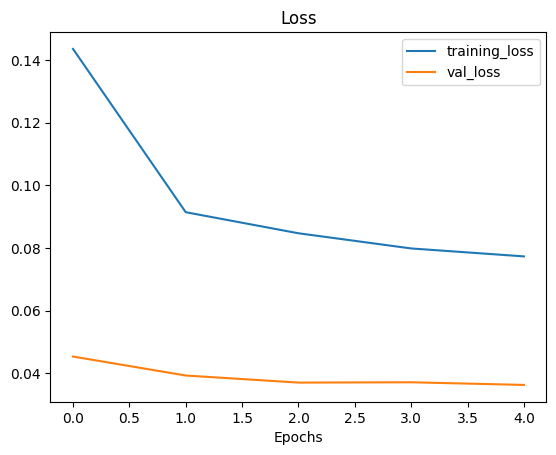

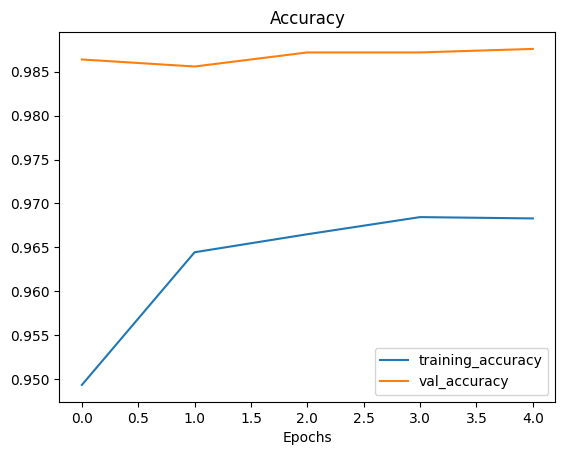

In [72]:
plot_loss_curves(efficientnet_history)

> Training vs Validation Loss

Training loss steadily decreases and is relatively low by epoch 5.
Validation loss starts low and also decreases slightly, stabilizing around ~0.037.
The model is generalizing very well.

> Training vs Validation Accuracy

Training accuracy increases nicely, reaching ~96.8%.
Validation accuracy is even higher (~98.7–98.8%) and very stable.

### Grid search/saving best models/custom images

In [149]:

# The images are split train-70%/valid-20%/test-10%
custom_train_dir = "CatDog_CustomImages/train"
custom_validation_dir = "CatDog_CustomImages/valid"
custom_test_dir = "CatDog_CustomImages/test"

custom_train_cats = os.path.join(custom_train_dir, "cat")
custom_train_dogs = os.path.join(custom_train_dir, "dog")

custom_validation_cats = os.path.join(custom_validation_dir, "cat")
custom_validation_dogs = os.path.join(custom_validation_dir, "dog")

custom_test_cats = os.path.join(custom_test_dir, "cat")
custom_test_dogs = os.path.join(custom_test_dir, "dog")

print("Length of the custom CAT directory (Amount of images) - TRAIN, VALIDATION, TEST: ", len(os.listdir(custom_train_cats)), len(os.listdir(custom_validation_cats)), len(os.listdir(custom_test_cats)))

print("Length of the custom DOG directory (Amount of images) - TRAIN, VALIDATION, TEST: ", len(os.listdir(custom_train_dogs)), len(os.listdir(custom_validation_dogs)), len(os.listdir(custom_test_dogs)))

Length of the custom CAT directory (Amount of images) - TRAIN, VALIDATION, TEST:  14 4 2
Length of the custom DOG directory (Amount of images) - TRAIN, VALIDATION, TEST:  14 4 2


Image shape: (676, 1024, 3)
Image shape: (485, 583, 3)


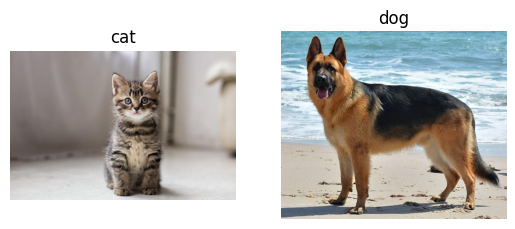

In [27]:
plt.figure()
plt.subplot(1, 2, 1)
cat_img = view_random_image(custom_train_dir, "cat")
plt.subplot(1, 2, 2)
dog_img = view_random_image(custom_train_dir, "dog")

In [28]:
# Set random seed
tf.random.set_seed(42)

# Preprocess the images/Data augmentation (normalization, rotation, ...)
custom_train_dataset_augmented = ImageDataGenerator(rescale=1/255.,
                                            brightness_range=(0.8, 1.2),
                                            rotation_range=30,
                                            shear_range=0.2,
                                            zoom_range=0.3,
                                            width_shift_range=0.2,
                                            height_shift_range=0.2,
                                            horizontal_flip=True)

In [38]:
custom_train_batch_non_augmented = ImageDataGenerator(rescale=1/255.).flow_from_directory(custom_train_dir,
                                                          target_size=(224,224),
                                                          batch_size=8,
                                                          class_mode='binary',
                                                          shuffle=False)

custom_train_batch_augmented = custom_train_dataset_augmented.flow_from_directory(custom_train_dir,
                                                          target_size=(224,224),
                                                          batch_size=8,
                                                          class_mode='binary',
                                                          shuffle=False)

Found 24 images belonging to 2 classes.
Found 24 images belonging to 2 classes.


Text(0.5, 1.0, 'Custom augmented image')

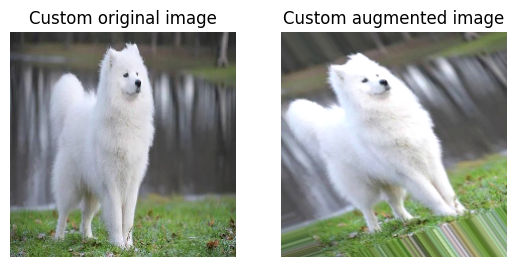

In [44]:
custom_images, custom_labels = next(custom_train_batch_non_augmented)
custom_augmented_images, custom_labels = next(custom_train_batch_augmented)

random_number = random.randint(0, 7)
plt.figure()
plt.subplot(1, 2, 1)
plt.title(f"Custom original image")
plt.axis("off")
plt.imshow(custom_images[random_number])
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(custom_augmented_images[random_number])
plt.title(f"Custom augmented image")

In [156]:
# Shuffling the training data and making validation and test batches
custom_train_batch_augmented = custom_train_dataset_augmented.flow_from_directory(custom_train_dir,
                                                          target_size=(224,224),
                                                          batch_size=8,
                                                          class_mode='binary',
                                                          shuffle=True)

custom_validation_batch_non_augmented = ImageDataGenerator(rescale=1/255.).flow_from_directory(custom_validation_dir,
                                                          target_size=(224,224),
                                                          batch_size=8,
                                                          class_mode='binary',
                                                          shuffle=False)

custom_test_batch_non_augmented = ImageDataGenerator(rescale=1/255.).flow_from_directory(custom_test_dir,
                                                          target_size=(224,224),
                                                          batch_size=8,
                                                          class_mode='binary',
                                                          shuffle=False)

Found 28 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [143]:
import importlib, grid_search
importlib.reload(grid_search)
from grid_search import run_grid

df_results, best_model = run_grid(
    train_gen=custom_train_batch_augmented,    
    val_gen=custom_validation_batch_non_augmented,
    optimizers=("adam", "sgd"),
    learning_rates=(1e-3, 1e-4),
    activations=("relu", "leaky_relu"),
    dropouts=(0.2, 0.3),
    batchnorm=(True, False),
    poolings=("max","avg"),
    filters_list=((10, 10, 10),),
    epochs=10,   
    verbose=1,
    save_best_model_path="best_grid_model"
)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - accuracy: 0.6354 - loss: 0.7853 - precision: 0.5833 - recall: 0.2024 - val_accuracy: 0.5000 - val_loss: 0.6909 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.5312 - loss: 1.2394 - precision: 0.5095 - recall: 0.9583 - val_accuracy: 0.5000 - val_loss: 0.6902 - val_precision: 0.5000 - val_recall: 0.6667 - learning_rate: 0.0010
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.5417 - loss: 0.8693 - precision: 0.5179 - recall: 0.4345 - val_accuracy: 0.5000 - val_loss: 0.6928 - val_precision: 0.5000 - val_recall: 0.3333 - learning_rate: 0.0010
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5469 - loss: 1.1176 - precision: 0.7917 - recall: 0.4351 - val_accuracy: 0.5000 - val_loss: 0.6964 - val_precision: 0.5000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.7135 - l

c:\Users\Nin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 298ms/step - accuracy: 0.4271 - loss: 0.9316 - precision: 0.2708 - recall: 0.1875 - val_accuracy: 0.5000 - val_loss: 0.6822 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.6250 - loss: 0.6698 - precision: 0.6500 - recall: 0.5208 - val_accuracy: 0.5000 - val_loss: 0.6813 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.4792 - loss: 0.9689 - precision: 0.4594 - recall: 0.4405 - val_accuracy: 0.5000 - val_loss: 0.6782 - val_precision: 0.5000 - val_recall: 0.1667 - learning_rate: 0.0010
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.5000 - loss: 0.7669 - precision: 0.5417 - recall: 0.5583 - val_accuracy: 0.5833 - val_loss: 0.6808 - val_precision: 0.5455 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accu


Top 1 model hyperparameters:
  Optimizer: sgd
  Learning rate: 0.0001
  Activation: leaky_relu
  Dropout: 0.3
  BatchNorm: True
  Pooling: max
  Val Accuracy: 0.6667, Val F1: 0.7500

Top 2 model hyperparameters:
  Optimizer: sgd
  Learning rate: 0.001
  Activation: leaky_relu
  Dropout: 0.2
  BatchNorm: True
  Pooling: max
  Val Accuracy: 0.6667, Val F1: 0.7500

Top 3 model hyperparameters:
  Optimizer: sgd
  Learning rate: 0.0001
  Activation: relu
  Dropout: 0.2
  BatchNorm: False
  Pooling: max
  Val Accuracy: 0.6667, Val F1: 0.7143


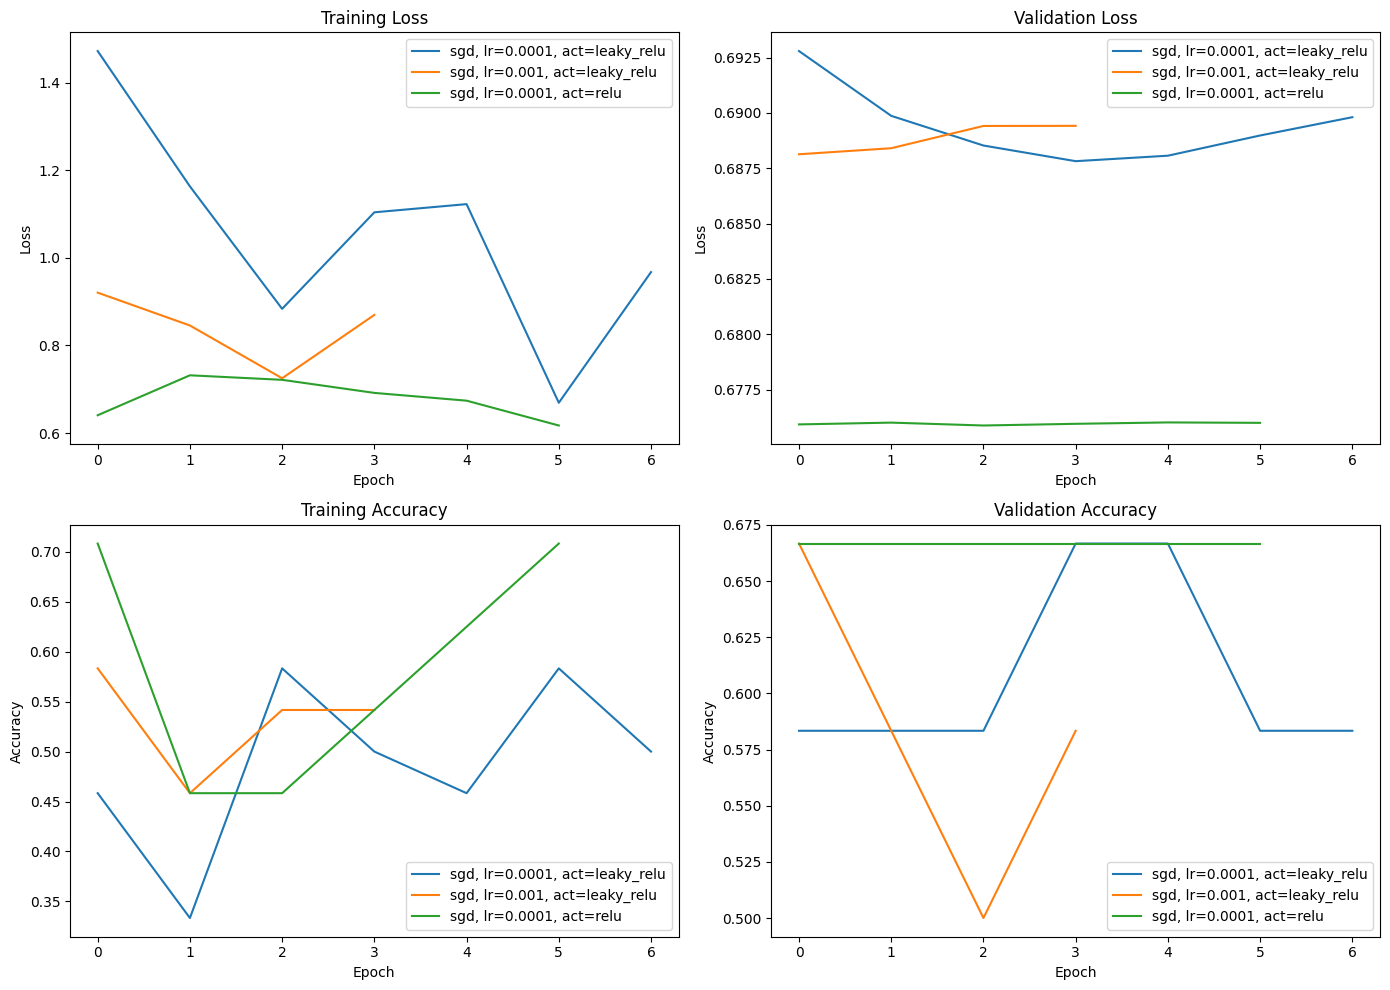

In [146]:
top3 = df_results.head(3)

plt.figure(figsize=(14, 10))

for idx, (_, row) in enumerate(top3.iterrows(), start=1):
    history = row["history"]

    print(f"\nTop {idx} model hyperparameters:")
    print(f"  Optimizer: {row['optimizer']}")
    print(f"  Learning rate: {row['learning_rate']}")
    print(f"  Activation: {row['conv_activation']}")
    print(f"  Dropout: {row['dropout']}")
    print(f"  BatchNorm: {row['batchnorm']}")
    print(f"  Pooling: {row['pooling']}")
    print(f"  Val Accuracy: {row['val_accuracy']:.4f}, Val F1: {row['val_f1']:.4f}")


    # Loss (train)
    plt.subplot(2, 2, 1)
    plt.plot(history["loss"], label=f"{row.optimizer}, lr={row.learning_rate}, act={row.conv_activation}")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Loss (val)
    plt.subplot(2, 2, 2)
    plt.plot(history["val_loss"], label=f"{row.optimizer}, lr={row.learning_rate}, act={row.conv_activation}")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy (train)
    plt.subplot(2, 2, 3)
    plt.plot(history["accuracy"], label=f"{row.optimizer}, lr={row.learning_rate}, act={row.conv_activation}")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Accuracy (val)
    plt.subplot(2, 2, 4)
    plt.plot(history["val_accuracy"], label=f"{row.optimizer}, lr={row.learning_rate}, act={row.conv_activation}")
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

plt.tight_layout()
plt.show()


### Loading a presaved custom model and training it on more data

In [153]:
best_grid_search_model = load_model("best_grid_model_1755720098.keras")
best_grid_search_model.summary()

for layer in best_grid_search_model.layers[:-3]:  
    layer.trainable = False

best_grid_search_model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss="binary_crossentropy",
    metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
)

history_best_grid_search_model = best_grid_search_model.fit(
    train_batch_augmented,
    validation_data=validation_batch_non_augmented,
    epochs=5
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 10)   │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 222, 222, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 10)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 10)   │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 10)   │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 10)     │           910 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6760)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         6,761 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,983 (35.09 KB)

 Trainable params: 8,921 (34.85 KB)

 Non-trainable params: 60 (240.00 B)

 Optimizer params: 2 (12.00 B)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 312ms/step - accuracy: 0.5223 - loss: 0.7075 - precision: 0.4169 - recall: 0.3204 - val_accuracy: 0.5649 - val_loss: 0.6858 - val_precision: 0.6746 - val_recall: 0.2506
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 314ms/step - accuracy: 0.5328 - loss: 0.6976 - precision: 0.5505 - recall: 0.5698 - val_accuracy: 0.5372 - val_loss: 0.6998 - val_precision: 0.7104 - val_recall: 0.1257
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 195s 309ms/step - accuracy: 0.5493 - loss: 0.6940 - precision: 0.5557 - recall: 0.5191 - val_accuracy: 0.5725 - val_loss: 0.6706 - val_precision: 0.5454 - val_recall: 0.8703
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 313ms/step - accuracy: 0.5432 - loss: 0.6930 - precision: 0.5383 - recall: 0.5798 - val_accuracy: 0.5168 - val_loss: 0.7023 - val_precision: 0.5087 - val_recall: 0.9856
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 314ms/step - accuracy: 0.5513 - loss: 0.6899 - precision: 0.5385 - recall: 0.5596 - val_accuracy: 0.6073

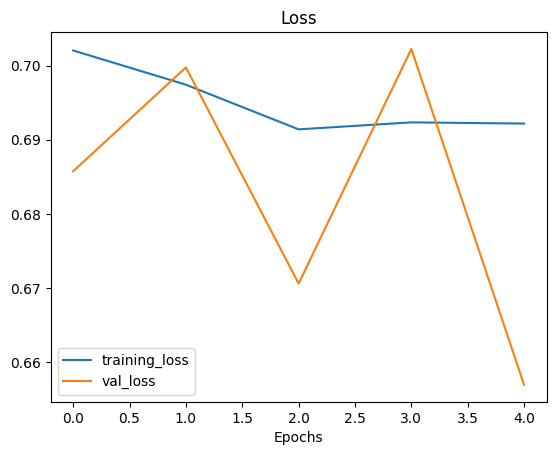

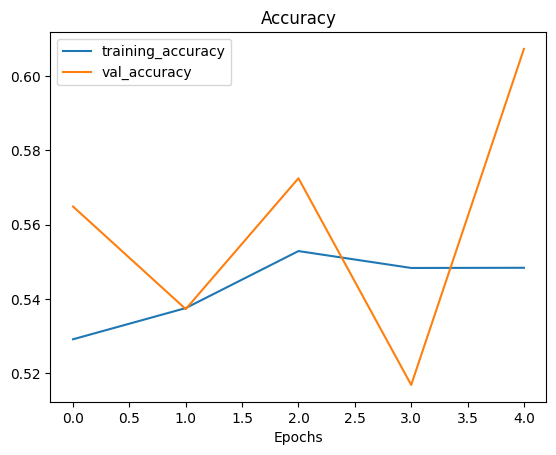

In [155]:
plot_loss_curves(history_best_grid_search_model)

The model can’t get good training performance, it hasn’t captured the patterns → underfitting.

### Predicting

In [88]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  img = tf.io.read_file(filename)

  img = tf.image.decode_image(img, channels=3)

  img = tf.image.resize(img, size = [img_shape, img_shape])

  img = img/255.
  return img

In [106]:
cat = load_and_prep_image("Predict_Images/cat01.jpg")
cat

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.99404764, 0.9780237 , 0.7992297 ],
        [0.99285716, 0.98109245, 0.77464986],
        [0.99285716, 0.9771709 , 0.7936825 ],
        ...,
        [0.86877495, 0.9001475 , 0.7484514 ],
        [0.882703  , 0.9126376 , 0.770453  ],
        [0.9126625 , 0.9244272 , 0.813082  ]],

       [[0.99695635, 0.9864146 , 0.83246547],
        [0.9981793 , 0.9863445 , 0.8383754 ],
        [0.9981793 , 0.9845938 , 0.8436975 ],
        ...,
        [0.80642027, 0.87385744, 0.63048697],
        [0.82431465, 0.88551915, 0.68705976],
        [0.87475187, 0.903426  , 0.7473002 ]],

       [[0.9956582 , 0.9956582 , 0.8614846 ],
        [1.        , 0.99234444, 0.89761907],
        [1.        , 0.9925771 , 0.89327735],
        ...,
        [0.75700223, 0.858963  , 0.57384574],
        [0.7956581 , 0.8858542 , 0.6775908 ],
        [0.86652595, 0.9079753 , 0.7561762 ]],

       ...,

       [[0.8691466 , 0.8925359 , 0.91606534],
        [0.70

In [ ]:
# Add an extra axis
cat = tf.expand_dims(cat, axis=0)
print(f"Shape after new dimension: {cat.shape}")
cat

Shape before new dimension: (224, 224, 3)
Shape after new dimension: (1, 224, 224, 3)


<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[0.99404764, 0.9780237 , 0.7992297 ],
         [0.99285716, 0.98109245, 0.77464986],
         [0.99285716, 0.9771709 , 0.7936825 ],
         ...,
         [0.86877495, 0.9001475 , 0.7484514 ],
         [0.882703  , 0.9126376 , 0.770453  ],
         [0.9126625 , 0.9244272 , 0.813082  ]],

        [[0.99695635, 0.9864146 , 0.83246547],
         [0.9981793 , 0.9863445 , 0.8383754 ],
         [0.9981793 , 0.9845938 , 0.8436975 ],
         ...,
         [0.80642027, 0.87385744, 0.63048697],
         [0.82431465, 0.88551915, 0.68705976],
         [0.87475187, 0.903426  , 0.7473002 ]],

        [[0.9956582 , 0.9956582 , 0.8614846 ],
         [1.        , 0.99234444, 0.89761907],
         [1.        , 0.9925771 , 0.89327735],
         ...,
         [0.75700223, 0.858963  , 0.57384574],
         [0.7956581 , 0.8858542 , 0.6775908 ],
         [0.86652595, 0.9079753 , 0.7561762 ]],

        ...,

        [[0.8691466 , 0.8925359 , 

In [ ]:
print(train_batch_augmented.class_indices)

{'cat': 0, 'dog': 1}


In [103]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  img = load_and_prep_image(filename)

  pred = model.predict(tf.expand_dims(img, axis=0))

  pred_class = class_names[int(tf.round(pred)[0][0])]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


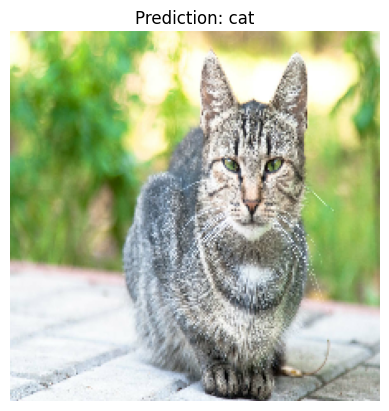

In [115]:
pred_and_plot(model_1, "Predict_Images/cat01.jpg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


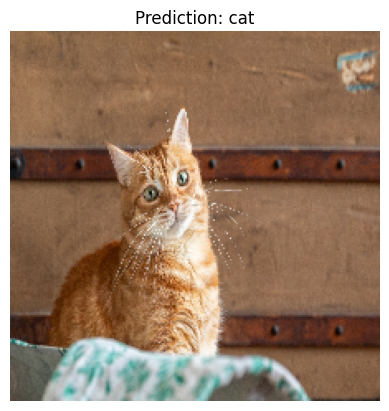

In [116]:
pred_and_plot(model_1, "Predict_Images/cat02.jpg", class_names)

1/1 [==============================] - 1s 1s/step


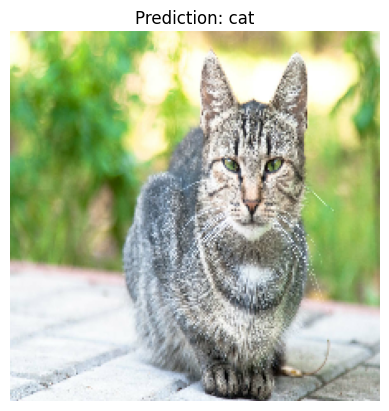

In [ ]:
pred_and_plot(resnet_model, "Predict_Images/cat01.jpg", class_names)

1/1 [==============================] - 1s 832ms/step


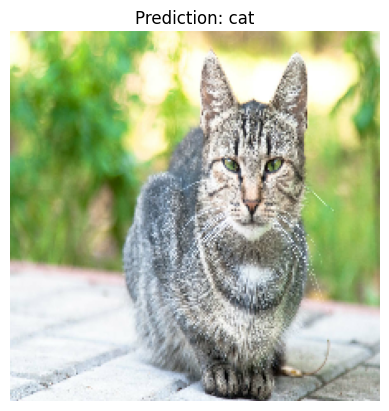

In [110]:
pred_and_plot(efficientnet_model, "Predict_Images/cat01.jpg", class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


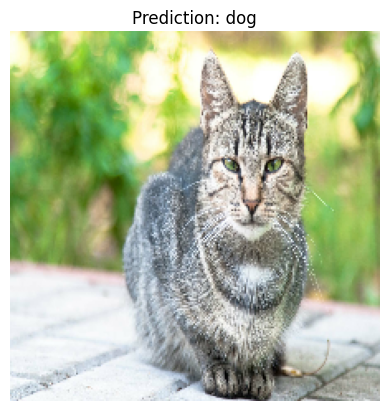

In [170]:
pred_and_plot(model_5, "Predict_Images/cat01.jpg", class_names)